In [1]:
import os
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

from tqdm import tqdm
from tensorboard_logger import configure, log_value

import torch
import torch.nn as nn
import torch.optim as optim

import torch.utils.data
from torch.utils.data import DataLoader

import torchvision.utils as utils

from srwgan.generator_srwgan import Generator
from srwgan.discriminator_srgan import Discriminator

from srwgan.utils import TrainDataset, DevDataset, to_image

import random
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Parameters

In [2]:
n_epoch_pretrain = 2
use_tensorboard = True

crop_size = 512
num_epochs = 10
batch_size = 4
#train_set='srwgan/archive/anime_face'
train_set='srwgan/archive/small_data'
dev_set = 'srwgan/archive/dev_anime_face'
check_point=-1

input_size = crop_size
n_epoch = num_epochs
batch_size = batch_size
check_point = check_point

check_point_path = 'srwgan/cp/'
if not os.path.exists(check_point_path):
	os.makedirs(check_point_path)

train_set = TrainDataset(train_set, crop_size=input_size, upscale_factor=8)
train_loader = DataLoader(dataset=train_set, num_workers=2, batch_size=batch_size, shuffle=True)

dev_set = DevDataset(dev_set, upscale_factor=8)
dev_loader = DataLoader(dataset=dev_set, num_workers=1, batch_size=1, shuffle=False)

mse = nn.MSELoss()
bce = nn.BCELoss()
	
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
	print ('##################USING CPU####################')

netG = Generator()
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator()
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

# pass to gpu if available
netG.to(device)
netD.to(device)
mse.to(device)
bce.to(device)

if use_tensorboard:
	configure('log', flush_secs=5)

# generator parameters: 807692
# discriminator parameters: 5215425


c:\Users\luca9\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [3]:
! pip install torchsummary

In [4]:
from torchsummary import summary

summary(netG, (3,64,64))
summary(netD, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,616
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,928
       BatchNorm2d-7           [-1, 64, 64, 64]             128
     ResidualBlock-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          36,928
      BatchNorm2d-10           [-1, 64, 64, 64]             128
            PReLU-11           [-1, 64, 64, 64]               1
           Conv2d-12           [-1, 64, 64, 64]          36,928
      BatchNorm2d-13           [-1, 64, 64, 64]             128
    ResidualBlock-14           [-1, 64,

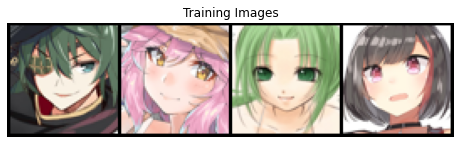

In [5]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Pre-train

In [6]:
# Pre-train generator using only MSE loss
if check_point == -1:
	optimizerG = optim.Adam(netG.parameters())
	for epoch in range(1, n_epoch_pretrain + 1):
		train_bar = tqdm(train_loader)
		
		netG.train()
		
		cache = {'g_loss': 0}

		for lowres, real_img_hr in train_bar:
			real_img_hr = real_img_hr.to(device)
				
			lowres = lowres.to(device)
				
			fake_img_hr = netG(lowres)

			# Train G
			netG.zero_grad()
			
			image_loss = mse(fake_img_hr, real_img_hr)
			cache['g_loss'] += image_loss
			
			image_loss.backward()
			optimizerG.step()

			# Print information by tqdm
			train_bar.set_description(desc='[%d/%d] Loss_G: %.4f' % (epoch, n_epoch_pretrain, image_loss))
			
	# Save model parameters	
	torch.save(netG.state_dict(), 'srwgan/cp/netG_epoch_pre_gpu.pth')

  0%|          | 0/22035 [00:00<?, ?it/s]

  0%|          | 0/22035 [00:00<?, ?it/s]


  0%|          | 0/22035 [00:00<?, ?it/s]

  0%|          | 0/22035 [00:00<?, ?it/s]


[2/2] Loss_G: 0.0038: 100%|██████████| 22035/22035 [1:44:35<00:00,  3.51it/s]


# Prepare for training

In [7]:
optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

if check_point != -1:
	netG.load_state_dict(torch.load('cp/netG_epoch_' + str(check_point) + '_gpu.pth'))
	netD.load_state_dict(torch.load('cp/netD_epoch_' + str(check_point) + '_gpu.pth'))
	optimizerG.load_state_dict(torch.load('cp/optimizerG_epoch_' + str(check_point) + '_gpu.pth'))
	optimizerD.load_state_dict(torch.load('cp/optimizerD_epoch_' + str(check_point) + '_gpu.pth'))

# Training

In [8]:
if __name__ == '__main__':

	for epoch in range(1 + max(check_point, 0), n_epoch + 1 + max(check_point, 0)):
		train_bar = tqdm(train_loader)
		
		netG.train()
		netD.train()
		
		cache = {'mse_loss': 0, 'adv_loss': 0, 'g_loss': 0, 'd_loss': 0}


		for lowres, real_img_hr in train_bar:
			#print ('lr size : ' + str(data.size()))
			#print ('hr size : ' + str(target.size()))
			#if torch.cuda.is_available():
			real_img_hr = real_img_hr.to(device)
			lowres = lowres.to(device)
			
			#######################################################
			# Train Discriminator
			#######################################################

			#if not check_grads(netD, 'D'):
			#	return
			netD.zero_grad()
			
			logits_real = netD(real_img_hr)
			logits_fake = netD(netG(lowres).detach())
			
			# Lable smoothing
			real = torch.tensor(torch.rand(logits_real.size())*0.25 + 0.85)
			fake = torch.tensor(torch.rand(logits_fake.size())*0.15)
			
			# Lable flipping
			prob = (torch.rand(logits_real.size()) < 0.05)
			
			#print ('logits real size : ' + str(logits_real.size()))
			#print ('logits fake size : ' + str(logits_fake.size()))
			
			#if torch.cuda.is_available():
			real = real.to(device)
			fake = fake.to(device)
			prob = prob.to(device)
				
			real_clone = real.clone()
			real[prob] = fake[prob]
			fake[prob] = real_clone[prob]
			
			d_loss = bce(logits_real, real) + bce(logits_fake, fake)
			
			cache['d_loss'] += d_loss.item()
			
			d_loss.backward()
			optimizerD.step()

			#######################################################
			# Train Generator
			#######################################################

			#if not check_grads(netG, 'G'):
			#	return
			netG.zero_grad()
			
			fake_img_hr = netG(lowres)
			image_loss = mse(fake_img_hr, real_img_hr)
			
			logits_fake_new = netD(fake_img_hr)
			adversarial_loss = bce(logits_fake_new, torch.ones_like(logits_fake_new))
			
			g_loss = image_loss + 1e-2*adversarial_loss

			cache['mse_loss'] += image_loss.item()
			cache['adv_loss'] += adversarial_loss.item()
			cache['g_loss'] += g_loss.item()

			g_loss.backward()
			optimizerG.step()

			# Print information by tqdm
			train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f = %.4f + %.4f' % (epoch, n_epoch, d_loss, g_loss, image_loss, adversarial_loss))
		
		if use_tensorboard:
			log_value('d_loss', cache['d_loss']/len(train_loader), epoch)
		
			log_value('mse_loss', cache['mse_loss']/len(train_loader), epoch)
			log_value('adv_loss', cache['adv_loss']/len(train_loader), epoch)
			log_value('g_loss', cache['g_loss']/len(train_loader), epoch)
		
		# Save model parameters	
		#if torch.cuda.is_available():
		torch.save(netG.state_dict(), 'cp/netG_epoch_%d_gpu.pth' % (epoch))
		if epoch%5 == 0:
			torch.save(netD.state_dict(), 'cp/netD_epoch_%d_gpu.pth' % (epoch))
			torch.save(optimizerG.state_dict(), 'cp/optimizerG_epoch_%d_gpu.pth' % (epoch))
			torch.save(optimizerD.state_dict(), 'cp/optimizerD_epoch_%d_gpu.pth' % (epoch))

  0%|          | 0/22035 [00:00<?, ?it/s]C:\Users\luca9\AppData\Local\Temp/ipykernel_20144/4121659371.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real = torch.tensor(torch.rand(logits_real.size())*0.25 + 0.85)
C:\Users\luca9\AppData\Local\Temp/ipykernel_20144/4121659371.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake = torch.tensor(torch.rand(logits_fake.size())*0.15)
[1/10] D grads:(0.001028, 0.000705) G grads:(0.000019, 0.000000) Loss_D: 1.3676 Loss_G: 0.0086 = 0.0034 + 0.5176: 100%|██████████| 22035/22035 [4:26:03<00:00,  1.38it/s]  
[2/10] D grads:(0.008790, 0.016209) G grads:(0.000046, 0.000000) Loss_D: 1.2912 Loss_G: 0.0134 = 0.0056 + 0.7817: 100%|██████████| 220

KeyboardInterrupt: 

In [9]:
check_point = 5
netG.load_state_dict(torch.load('cp/netG_epoch_' + str(check_point) + '_gpu.pth'))
netD.load_state_dict(torch.load('cp/netD_epoch_' + str(check_point) + '_gpu.pth'))
optimizerG.load_state_dict(torch.load('cp/optimizerG_epoch_' + str(check_point) + '_gpu.pth'))
optimizerD.load_state_dict(torch.load('cp/optimizerD_epoch_' + str(check_point) + '_gpu.pth'))

# Evaluate

In [11]:
if __name__ == '__main__':
	# Visualize results
	with torch.no_grad():
		netG.eval()
		out_path = 'vis/'
		if not os.path.exists(out_path):
			os.makedirs(out_path)
			
		dev_bar = tqdm(dev_loader)
		valing_results = {'mse': 0, 'batch_sizes': 0}
		dev_images = []
		for val_lr, val_hr_restore, val_hr in dev_bar:
			batch_size = val_lr.size(0)
			lr = val_lr
			hr = val_hr
			lr = lr.to(device)
			hr = hr.to(device)
			sr = netG(lr)
			
			dev_bar.set_description(desc='[converting LR images to SR images]')
			
			# Avoid out of memory crash on 8G GPU
			if len(dev_images) < 60 :
				dev_images.extend([to_image()(val_hr_restore.squeeze(0)), to_image()(hr.data.cpu().squeeze(0)), to_image()(sr.data.cpu().squeeze(0))])
		
		dev_images = torch.stack(dev_images)
		dev_images = torch.chunk(dev_images, dev_images.size(0) // 3)
		
		dev_save_bar = tqdm(dev_images, desc='[saving training results]')
		index = 1
		for image in dev_save_bar:
			image = utils.make_grid(image, nrow=3, padding=5)
			utils.save_image(image, out_path + 'last_epoch_%d_index_%d.png' % (epoch, index), padding=5)
			index += 1

[converting LR images to SR images] PSNR: 20.3756 dB SSIM: 0.0000: 100%|██████████| 3824/3824 [01:37<00:00, 39.28it/s]
[saving training results]: 100%|██████████| 20/20 [00:04<00:00,  4.18it/s]
